[8.6495073e-01 4.3800000e-04 4.4168000e-04]
[-1.05488617e-02 -1.36419228e+03]


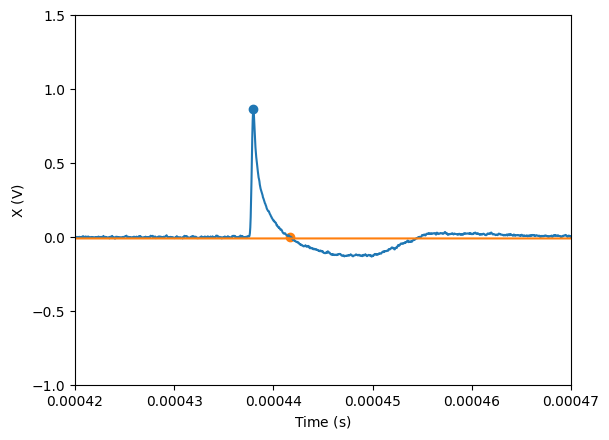

In [3]:
# importing necessary packages for data analysis.
import numpy as np
import sys
sys.path.append("../../lhillber/brownian/src")
from time_series import CollectionTDMS as ctdms
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# data from 07/17 Sagnac/Sagnac_fire_19J is complete shit
# we need to retake this data and make sure that the signal is being 
# taken correctly. For now, I'm using the data from 07/14 because it
# is a better representation of what our data should look like.
d = "../data/20230801/Sagnac/iter_0.tdms"
laser = ctdms(d)
micro = ctdms(d)
laser.set_collection("X")
laser.apply("detrend", mode = "linear", inplace = True)
laser.apply("calibrate", cal = -1, inplace = True)
micro.set_collection("Y")
fig, ax = plt.subplots()

shot = laser.collection[3]
shot.plot(tmin = 4.2e-4, tmax = 4.7e-4, ax = ax)
def friedlander(t, peak, tau):
    return peak * np.exp((-t / tau)) * (1 - (t / tau))

peak_index = np.where(shot.x == max(shot.x))[0][0]
z_crossing = peak_index + np.where(np.diff(np.sign(shot.x[peak_index:])))[0][0]
ax.scatter(shot.t[peak_index], shot.x[peak_index])
ax.scatter(shot.t[z_crossing], shot.x[z_crossing])
guess = np.array([shot.x[peak_index], shot.t[peak_index], shot.t[z_crossing]])
popt, pcov = curve_fit(friedlander, shot.t[peak_index : z_crossing + 500], shot.x[peak_index : z_crossing + 500], maxfev = 100000)
ax.plot(shot.t, friedlander(shot.t, *popt))
print(guess)
print(popt)
ax.set_xlim([4.2e-4, 4.7e-4])
ax.set_ylim([-1, 1.5])
plt.show()

In [74]:
import numpy as np
import sys
sys.path.append("../../lhillber/brownian/src")
from time_series import CollectionTDMS as ctdms
import matplotlib.pyplot as plt
from acoustic_entrainment import mic_response
def local_detrend(col, tmin = None, tmax = None, inplace = False) -> None:
    for c in col.collection:
        t, x = c.time_gate(tmin = tmin, tmax = tmax)
        x_bar = np.mean(x)
        m, b = np.polyfit(t, x, 1)
        if inplace:
            c.x = c.x - (m * c.t) - b
    return None
def SNR(data, freq_cutoffs, bin_avg = False, laser = True) -> []:
    import numpy as np
    import sys
    sys.path.append("../../lhillber/brownian/src")
    from time_series import CollectionTDMS as ctdms
    import matplotlib.pyplot as plt
    from acoustic_entrainment import mic_response
    
    snr = []
    for f in freq_cutoffs:
        col = ctdms(data)
        if laser:
            col.set_collection("X")
        else:
            col.set_collection("Y")
        peaks = np.array([])
        rms = np.array([])
        if bin_avg:
            N = col.r / (2 * f)
            col.apply("bin_average", Npts = N, inplace = True)
        else:
            col.apply("lowpass", cutoff = f, inplace = True)
        local_detrend(col, tmin = 1.7e-4, tmax = 4e-4, inplace = True)
        if laser:
            col.apply("calibrate", cal = -1, inplace = True)
        else:
            col.apply("correct", response = mic_response, recollect = True)
        for s in col.collection[1:]:
            peaks = np.append(peaks, max(s.time_gate(tmin = 4e-4, tmax = 5e-4)[1]))
            rms = np.append(rms, np.std(s.time_gate(tmin = 1.7e-4, tmax = 4e-4)[1]))
        snr.append(np.mean(peaks / rms))
    return snr
def SNRvsFreq(data, freqs, titles, bins = False, save_fig = False, fig_title = "defaul_SNR.png") -> []:
    import numpy as np
    import sys
    sys.path.append("../../lhillber/brownian/src")
    from time_series import CollectionTDMS as ctdms
    import matplotlib.pyplot as plt
    from acoustic_entrainment import mic_response
    
    if save_fig:
        fig, ax = plt.subplots()
    snrs = []
    for i in range(len(titles)):
        if titles[i][:3] == "mic":
            snrs.append(SNR(data[i], freqs[i], bins, False))
        else:
            snrs.append(SNR(data[i], freqs[i], bins))
        if save_fig:
            ax.plot(freqs[i], snrs[i], label = titles[i])
    if save_fig:
        ax.set_title("SNR vs frequency at 19J.")
        ax.set_xlabel("frequency")
        ax.set_ylabel("SNR")
        fig.legend()
        fig.savefig(fig_title)
        fig.close()
    return snrs

data = ["../data/20230801/Sagnac/iter_0.tdms", "../data/20230801/Sagnac/iter_0.tdms", "../data/20230801/SplitBeam/iter_0.tdms", "../data/20230801/Telescope/iter_0.tdms"]
max_power_titles = ["sagnac", "microphone", "split", "telescope"]
freqs = [np.linspace(10000, 3000000, 50) for i in range(len(max_power_titles))]
# max_power = SNRvsFreq(data, freqs, max_power_titles)
phis = ["phi" + str(int(np.append(82, np.linspace(145, 160, 16))[i])) + ".tdms" for i in range(len(np.append(82, np.linspace(145, 160, 16))))]
min_detect_systems = ["../data/20230801/Sagnac/MinDetect/", "../data/20230801/Sagnac/MinDetect/", "../data/20230801/SplitBeam/MinDetect/", "../data/20230801/Telescope/MinDetect/"]
data = [m + p for m in min_detect_systems for p in phis]
titles = [t + " " + p[:-5] for t in max_power_titles for p in phis]
freqs = [np.linspace(10000, 1000000, 10) for i in range(len(data))]
# s = SNRvsFreq(data, freqs, titles)
# s_with_bins = SNRvsFreq(data, freqs, titles, bins = True)

# 1MHz 200kHz 1MHz 1MHz
sys_cutoffs = [1e6, 2e5]
f = np.linspace(10000, 1000000, 10)
resolution = 10
def makeSNRs(system_names, freq_scan, r, phis, sys_cutoffs):
    s = []
    max_power_titles = system_names
    sys_cutoffs = sys_cutoffs
    f = freq_scan
    resolution = r
    for i in range(len(max_power_titles)):
        if max_power_titles[i][:3] == "mic":
            system = (max_power_titles[i], np.linspace(10000, sys_cutoffs[1], resolution), [int(p[3:-5]) for p in phis], ([], []), (sys_cutoffs[1], []))
            for p in phis:
                d = min_detect_systems[i] + p
                system[3][0].append(SNR(d, f, laser = False))
                system[3][1].append(SNR(d, f, True, False))
                system[4][1].append(SNR(d, [sys_cutoffs[1]], True)[0])
            s.append(system)
        else:
            system = (max_power_titles[i], np.linspace(10000, sys_cutoffs[0], resolution), [int(p[3:-5]) for p in phis], ([], []), (sys_cutoffs[0], []))
            for p in phis:
                d = min_detect_systems[i] + p
                system[3][0].append(SNR(d, f))
                system[3][1].append(SNR(d, f, True))
                system[4][1].append(SNR(d, [sys_cutoffs[0]], True)[0])
            s.append(system)
    return s
snrs = makeSNRs(max_power_titles, f, resolution, phis, sys_cutoffs)

In [10]:
def printSystems(s) -> None:
    for i in s:
        print("\n================================================================================================")
        print("title:\t", i[0])
        print("\nfreq:\t", i[1])
        print("\nphis:\t", i[2])
        print("\nw/o bins:")
        for j in i[3][0]:
            print("\t", j)
        print("\nw/ bins:")
        for j in i[3][1]:
            print("\t", j)
        print("\nsystem freq. cutoff:")
        print("\t", i[4][0])
        print("\nSNR values at cutoff:")
        print("\t", i[4][1])
        print("------------------------------------------------------------------------------------------------\n")
    return None
# printSystems(snrs)
sagnac = System("sagnac", ["../data/20230801/Sagnac/iter_0.tdms"])
mic = System("microphone", ["../data/20230801/Sagnac/iter_0.tdms"])
print(sagnac.get_SNR_resolution())

10


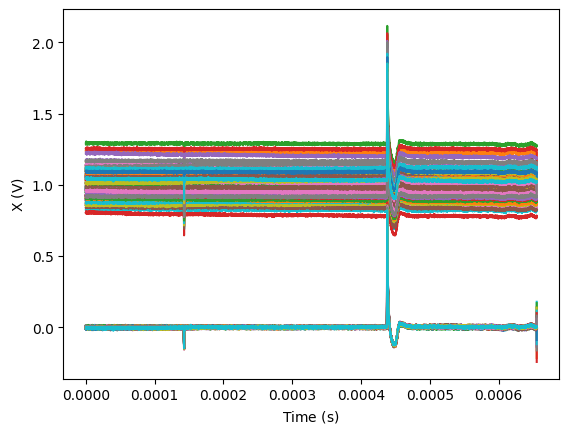

In [72]:
def local_detrend(col, tmin = None, tmax = None, inplace = False) -> None:
    for c in col.collection:
        t, x = c.time_gate(tmin = tmin, tmax = tmax)
        x_bar = np.mean(x)
        m, b = np.polyfit(t, x, 1)
        if inplace:
            c.x = c.x - (m * c.t) - b
    return None
d = "../data/20230801/Sagnac/iter_0.tdms"
laser = ctdms(d)
laser.set_collection("X")
fig, ax = plt.subplots()
laser.apply("calibrate", cal = -1, inplace = True)
for s in laser.collection[1:]:
    s.x += 1
    s.plot(ax = ax)
local_detrend(laser, tmin = 1.7e-4, tmax = 4e-4, inplace = True)
for s in laser.collection[1:]:
    s.plot(ax = ax)
plt.show()